C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Epoch 1, Reconstruction Error: 28.087468
Epoch 2, Reconstruction Error: 25.142613
Epoch 3, Reconstruction Error: 24.325959
Epoch 4, Reconstruction Error: 23.897269
Epoch 5, Reconstruction Error: 23.654467
Epoch 6, Reconstruction Error: 23.435158
Epoch 7, Reconstruction Error: 23.271789
Epoch 8, Reconstruction Error: 23.331686
Epoch 9, Reconstruction Error: 23.385507
Epoch 10, Reconstruction Error: 23.346574


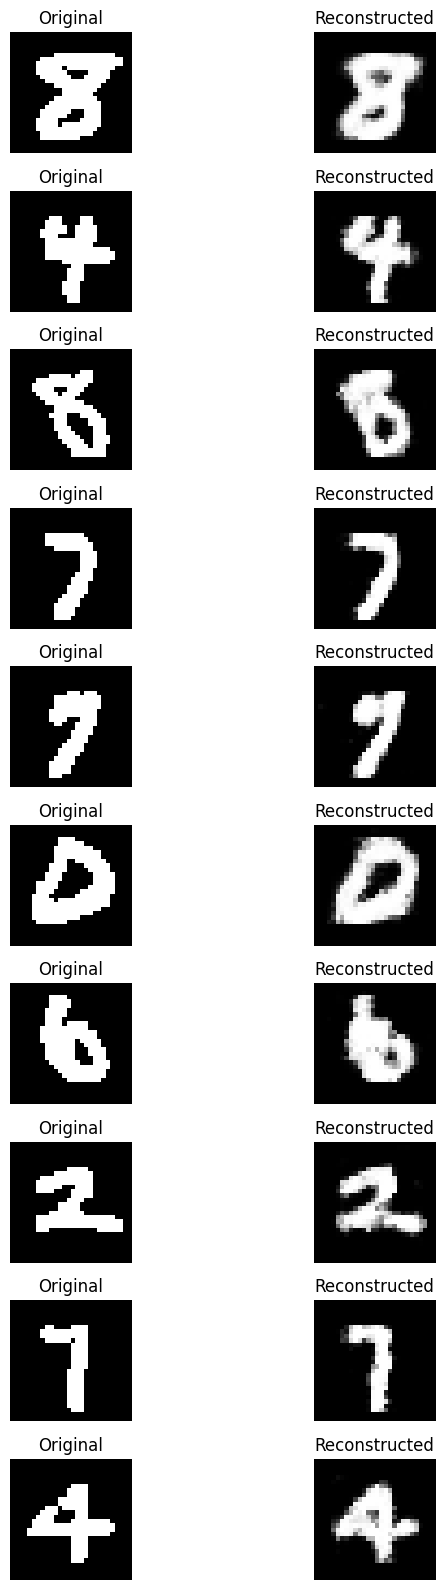

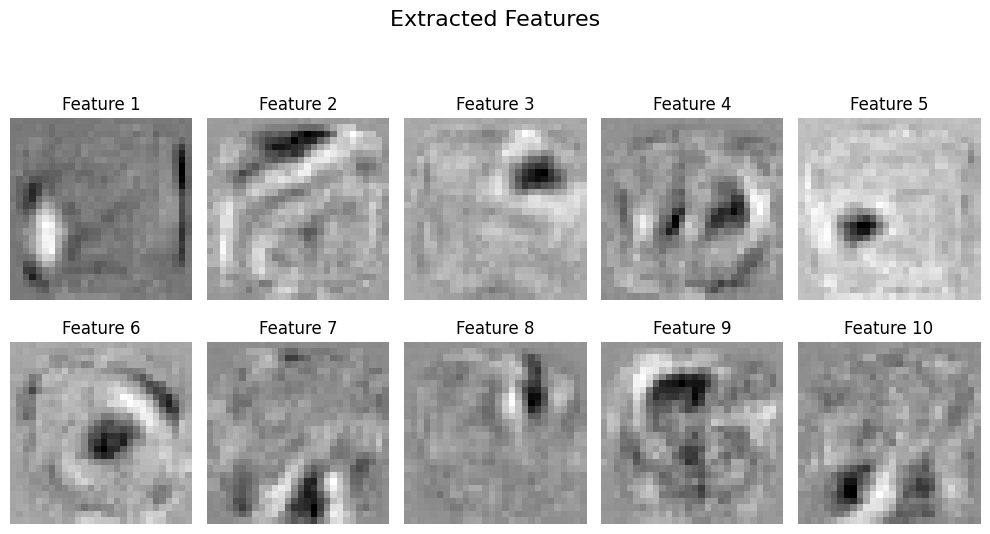

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize
import matplotlib.pyplot as plt

class RBM:
    def __init__(self, num_visible, num_hidden):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.weights = np.random.normal(0, 0.1, size=(num_visible, num_hidden))
        self.visible_bias = np.zeros(num_visible)
        self.hidden_bias = np.zeros(num_hidden)
        
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _gibbs_sampling(self, visible_prob):
        hidden_prob = self._sigmoid(np.dot(visible_prob, self.weights) + self.hidden_bias)
        
        
        visible_prob_reconstructed = self._sigmoid(np.dot(hidden_prob, self.weights.T) + self.visible_bias)
        
        
        return hidden_prob, visible_prob_reconstructed
    
    def train(self, data, learning_rate=0.1, num_epochs=100, k=1):
        num_samples = data.shape[0]
        
        for epoch in range(num_epochs):
            np.random.shuffle(data)
            error = 0
            
            for sample in data:
                visible_prob = sample
                hidden_prob,  visible_prob= self._gibbs_sampling(visible_prob)
                
                positive_association = np.outer(sample, hidden_prob)
                negative_association = np.outer(visible_prob, self._sigmoid(np.dot(visible_prob, self.weights) + self.hidden_bias))
                
                self.weights += learning_rate * (positive_association - negative_association)
                self.visible_bias += learning_rate * (sample - visible_prob)
                self.hidden_bias += learning_rate * (hidden_prob - self._sigmoid(np.dot(visible_prob, self.weights) + self.hidden_bias))
                
                error += np.sum((sample - visible_prob)**2)
            
            print("Epoch %d, Reconstruction Error: %f" % (epoch+1, error/num_samples))
    
    def reconstruct(self, data):
        hidden_prob = self._sigmoid(np.dot(data, self.weights) + self.hidden_bias)
        reconstructed_data = self._sigmoid(np.dot(hidden_prob, self.weights.T) + self.visible_bias)
        return reconstructed_data
    
    def extract_features(self, data):
        hidden_prob = self._sigmoid(np.dot(data, self.weights) + self.hidden_bias)
        return hidden_prob


mnist = fetch_openml('mnist_784')
X, y = mnist.data, mnist.target.astype(int)


X_bin = binarize(X, threshold=0.5)


X_train, X_test, _, _ = train_test_split(X_bin, y, test_size=0.2, random_state=42)


num_visible = X_train.shape[1]
num_hidden = 100  

rbm = RBM(num_visible, num_hidden)
rbm.train(X_train, num_epochs=10)
reconstructed_data = rbm.reconstruct(X_test)
features = rbm.extract_features(X_test)


num_samples = 10

fig, axes = plt.subplots(num_samples, 2, figsize=(8, 16))
for i in range(num_samples):
    axes[i, 0].imshow(X_test[i].reshape(28, 28), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original')
    
    axes[i, 1].imshow(reconstructed_data[i].reshape(28, 28), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Reconstructed')

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(rbm.weights[:, i].reshape(28, 28), cmap='gray')
    plt.title(f'Feature {i+1}')
    plt.axis('off')
plt.suptitle('Extracted Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
